# Using ART to Generate Adversarial Samples for a Deep Learning Model

This notebook shows how to use adversarial attack techniques from *Adversarial Robustness Toolbox* (*ART*) with *FfDL*. The ART library supports crafting and analyzing different attack and defense methods for deep learning models. 

In this notebook, you will learn how to incorporate one of the attack methods supported by ART, the *Fast Gradient Method* (*FGM*) into your training pipeline to generate adversarial samples for the purposes of evaluating the robustness of the trained model. In particular, the example in this notebook trains a *CNN* model on *MNIST* data and evaluates its robustness. 

The **ART** Github repository can be found here - https://github.com/IBM/adversarial-robustness-toolbox

Some familiarity with Python is helpful. This notebook uses Python 3.


## Contents

1.	[Set up the environment](#setup)
2.	[Create a Keras model](#model)
3.  [Train the model](#train)
4.	[Generate adversarial samples for a robustness check](#art)
5.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:

- To store model and training data, this notebook requires a [Cloud Object Storage (COS)](https://console.bluemix.net/catalog/services/cloud-object-storage) instance (a *lite plan* is offered and information about how to order storage is [here](https://dataplatform.ibm.com/docs/content/analyze-data/ml_dlaas_object_store.html)).
    - After you create COS instance, go to your COS dashboard.
    - Get the **Endpoint** tab in the COS instance's dashboard.
    - You also need the IBM Cloud authorization endpoint to be able to create COS resource object.
    - In the **Service credentials** tab, click **New Credential+**.
    - Add the "[HMAC](https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials)" **inline configuration parameter**: `{"HMAC":true}`, click **Add**.

    This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
    ```
      "cos_hmac_keys": {
            "access_key_id": "1234567890abcdefghijklmnopqrtsuv",
            "secret_access_key": "0987654321zxywvutsrqponmlkjihgfedcba1234567890ab"
       }
    ```

- It is recommended that you run this notebook inside a Python virtual environment. Make sure you have all required libraries installed.

**TODO**: Provide your cluster name and COS credentials

In [ ]:
ffdl_cluster_name          = ""  # Name of your Kubernetes cluster with FfDL deployed on it
cos_apikey                 = ""  # Cloud Object Storage API KEY
cos_hmac_access_key_id     = ""  # Cloud Object Storage HMAC Access Key ID
cos_hmac_secret_access_key = ""  # Cloud Object Storage HMAC Secret Access Key
cos_resource_instance_id   = ""  # Cloud Object Storage Resource Instance ID
cos_service_endpoint       = ""  # Cloud Object Storage service endpoint, i.e. 'https://s3-api.us-geo.objectstorage.softlayer.net'
cos_auth_endpoint          = ""  # Cloud Object Storage authorization endpoint, i.e. 'https://iam.bluemix.net/oidc/token' 

### 1.1. Verify or Install Required Python Libraries

In [2]:
import sys

def is_venv():
    return (hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix))

try:
    import keras, tensorflow, requests, wget, ibm_boto3, art
    print("All required libraries are installed.")
    !cat requirements.txt
except ModuleNotFoundError:
    if is_venv:
        print("Installing required libraries into virtual environment.")
        !python -m pip install -r requirements.txt
    else:
        print("Please install the required libraries.")
        !cat requirements.txt

Using TensorFlow backend.


All required libraries are installed.
keras>=2.1.6
tensorflow>=1.8
ipython>=5.0.0
jupyter>=1.0.0
requests>=2.12.0,<=2.18.4
wget
ibm-cos-sdk
git+git://github.com/IBM/adversarial-robustness-toolbox@master


### 1.2 Connect to Cloud Object Storage  (COS)

Enter your COS credentials in the following cell. You can find these credentials in your COS instance dashboard under the **Service credentials** tab.

**Note:** the HMAC key, described in [set up the environment](#setup) is included in these credentials.

In [3]:
# TODO: load credentials from a file or keep this to make things as obvious as possible

cos_credentials = {
  "apikey": cos_apikey,
  "cos_hmac_keys": {
    "access_key_id": cos_hmac_access_key_id,
    "secret_access_key": cos_hmac_secret_access_key
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance",
  "iam_apikey_name": "auto-generated-apikey-****************************",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/****************************",
  "resource_instance_id": cos_resource_instance_id
}

In [4]:
for prop in ["apikey", "resource_instance_id"]:
    assert cos_credentials[prop], "'%s' must be set in 'cos_credentials'" % prop
    
for prop in ["access_key_id", "secret_access_key"]:
    assert cos_credentials["cos_hmac_keys"][prop], "'%s' must be set in 'cos_credentials'" % prop

Create a `boto` resource to be able to write data to COS. The boto library `ibm-cos-sdk` allows Python developers to manage Cloud Object Storage (COS).

In [5]:
import ibm_boto3
from ibm_botocore.client import Config

cos = ibm_boto3.resource('s3',
                         config                  = Config(signature_version='oauth'),
                         endpoint_url            = cos_service_endpoint,
                         ibm_auth_endpoint       = cos_auth_endpoint,
                         ibm_api_key_id          = cos_credentials['apikey'],
                         ibm_service_instance_id = cos_credentials['resource_instance_id'])

Create two buckets, which you will use to store training data and training results.

**Note:** The bucket names must be unique.

In [6]:
from uuid import uuid4

bucket_uid = str(uuid4())
buckets = ['training-data-' + bucket_uid,
           'training-results-' + bucket_uid]

for bucket in buckets:
        print('Creating bucket "{}" ...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))
            
training_data_bucket = buckets[0]
training_result_bucket = buckets[1]


Creating bucket "training-data-37e1f443-9e20-47f7-962d-43b68c4e26a3" ...
Creating bucket "training-results-37e1f443-9e20-47f7-962d-43b68c4e26a3" ...


Now you should have 2 buckets.

### 1.3 Download MNIST training data and upload it to the COS buckets

Download the training data and upload it to the `training-data` bucket.
First, create a list of links for the training dataset.

In [7]:
# TODO: download original data set and convert to npz

# Create a list of links.
data_links = ['https://github.com/anupamamurthi/datasets-models/raw/master/mnist/training_data/mnist.npz']

The code in the next cell uploads files from links to your COS.

In [8]:
# Upload files from the links to COS
from urllib.request import urlopen

bucket_obj = cos.Bucket(training_data_bucket)

for data_link in data_links:
    filename=data_link.split('/')[-1]
    print('Uploading data {} ...'.format(filename))
    with urlopen(data_link) as data:
        bucket_obj.upload_fileobj(data, filename)
        print('{} is uploaded.'.format(filename))

Uploading data mnist.npz ...
mnist.npz is uploaded.


Have a look at the list of the created buckets and their contents.

In [9]:
for bucket_name in buckets:
    print(bucket_name)
    bucket_obj = cos.Bucket(bucket_name)
    for obj in bucket_obj.objects.all():
        print("  File: {}, {:4.2f}kB".format(obj.key, obj.size/1024))

training-data-37e1f443-9e20-47f7-962d-43b68c4e26a3
  File: mnist.npz, 11221.13kB
training-results-37e1f443-9e20-47f7-962d-43b68c4e26a3


You are done with COS, and you are ready to train your model!

<a id="model"></a>
## 2. Create the Keras model

In this section we:

- [2.1 Package the model definition](#zip)
- [2.2 Prepare the training definition metadata](#manifest)


### 2.1 Create the Model Zip File <a id="zip"></a>

Let's create the model [`convolutional_keras.py`](../edit/convolutional_keras.py) and add it to a zip file.

In [10]:
script_filename  = "convolutional_keras.py"
archive_filename = 'model.zip'

In [11]:
%%writefile $script_filename

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import keras
import numpy as np
import sys
import os

batch_size = 128
num_classes = 10
epochs = 1

img_rows, img_cols = 28, 28


def main(argv):
    if len(argv) < 2:
        sys.exit("Not enough arguments provided.")

    global image_path

    i = 1
    while i <= 2:
        arg = str(argv[i])
        if arg == "--data":
            image_path = os.path.join(os.environ["DATA_DIR"], str(argv[i+1]))
        i += 2


if __name__ == "__main__":
    main(sys.argv)

# load mnist npz file
f = np.load(image_path)
x_train = f['x_train']
y_train = f['y_train']
x_test = f['x_test']
y_test = f['y_test']
f.close()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

model_wt_path = os.environ["RESULT_DIR"] + "/keras_original_model.hdf5"
model.save(model_wt_path)
print("Model saved to file: %s" % model_wt_path)

model_def_path = os.environ["RESULT_DIR"] + "/keras_original_model.json"
model_json = model.to_json()
with open(model_def_path, "w") as json_file:
    json_file.write(model_json)
print("Model definition saved to file: %s" % model_def_path)


Writing convolutional_keras.py


In [12]:
!zip -r {archive_filename} {script_filename}

  adding: convolutional_keras.py (deflated 60%)


### 2.2 Prepare the Training Definition Metadata <a id="manifest"></a>
- *FfDL* does not have a *Keras* community image so we need to `pip`-install *Keras* prior to running the `training_command` 
- Your COS credentials are referenced in the `data_stores` > `connection` data.

In [13]:
import yaml

training_command = "pip3 install keras; python3 convolutional_keras.py --data ${DATA_DIR}/mnist.npz"

manifest = {
  "name": "keras_digit_recognition",
  "description": "Hand-written Digit Recognition Training",
  "version": "1.0",
  "gpus": 0,
  "cpus": 2,
  "memory": "2Gb",
  "data_stores": [
    {
      "id": "sl-internal-os",
      "type": "s3_datastore",
      "training_data": {
        "container": training_data_bucket
      },
      "training_results": {
        "container": training_result_bucket
      },
      "connection": {
        "type": "s3_datastore",
        "auth_url": cos_service_endpoint,
        "user_name": cos_credentials['cos_hmac_keys']['access_key_id'],
        "password": cos_credentials['cos_hmac_keys']['secret_access_key']
      }
    }
  ],
  "framework": {
    "name": "tensorflow",
    "version": "1.5.0-py3",
    "command": training_command
  },
  "evaluation_metrics": {
    "type": "tensorboard",
    "in": "$JOB_STATE_DIR/logs/tb"
  }
}

yaml.dump(manifest, open("manifest.yml", "w"), default_flow_style=False)

## 3. Train the model<a id="train"></a>

In this section, learn how to:
- [3.1 Setup the command line environment](#cmd_setup)
- [3.2 Train the model in the background](#backg)
- [3.3 Monitor the training log](#log)
- [3.4 Cancel the training](#cancel)

### 3.1 Setup the command line environment <a id="cmd_setup"></a>

Load the Kubernetes cluster configuration using the [BlueMix CLI](https://console.bluemix.net/docs/cli/index.html#overview). Make sure your machine is logged in with `bx login`.

In [14]:
%env VM_TYPE = ibmcloud
%env CLUSTER_NAME $ffdl_cluster_name 

import os

try:
    cluster_config = !bx cs cluster-config {os.environ["CLUSTER_NAME"]} | grep "export KUBECONFIG="
    os.environ["KUBECONFIG"] = cluster_config[-1].split("=")[-1]
except IndexError:
    print("The cluster %s could not be found." % os.environ["CLUSTER_NAME"])
    print("Run 'bx cs clusters' to list all clusters you have access to.")
    #!bx cs clusters
    raise

env: VM_TYPE=ibmcloud
env: CLUSTER_NAME=ffdl-with-art


Setup the AWS command with endpoint and credentials and show the list of buckets

In [15]:
# os.environ["AWS_DEFAULT_REGION"]    = "us-east-1"
# os.environ["AWS_ACCESS_KEY_ID"]     = cos_credentials["cos_hmac_keys"]["access_key_id"]
# os.environ["AWS_SECRET_ACCESS_KEY"] = cos_credentials["cos_hmac_keys"]["secret_access_key"]

# s3_endpoint_url     = cos_service_endpoint                   
# os.environ["s3cmd"] = "aws --endpoint-url=%s s3" % s3_endpoint_url

# !$s3cmd ls

Setup the DLaaS URL, username and password

In [16]:
notebook_dir   = os.getcwd()
ffdl_root_dir  = notebook_dir.replace("/etc/notebooks/art", "")

In [17]:
node_ip        = !(cd {ffdl_root_dir} && make --no-print-directory kubernetes-ip)
restapi_port   = !kubectl get service ffdl-restapi -o jsonpath='{.spec.ports[0].nodePort}'
dlaas_url      = "http://%s:%s" % (node_ip[0], restapi_port[0])

%env DLAAS_URL $dlaas_url
%env DLAAS_USERNAME = test-user
%env DLAAS_PASSWORD = test

env: DLAAS_URL=http://169.48.201.210:30020
env: DLAAS_USERNAME=test-user
env: DLAAS_PASSWORD=test


Obtain the correct CLI for your machine and run the training job with our Keras model

In [18]:
import platform

ffdl = "%s/cli/bin/ffdl-%s" % (ffdl_root_dir, "osx" if platform.system() == "Darwin" else "linux")

### 3.2 Train the model in the background<a id="backg"></a>


In [19]:
out = !{ffdl} train "manifest.yml" "model.zip"
out

["Deploying model with manifest 'manifest.yml' and model file 'model.zip'...",
 'Model ID: training-NZEqlaIig',
 'OK']

### 3.3  Monitor the training log<a id="log"></a>

In [20]:
if "Model ID" in out[1]:
    model_id = out.fields()[1][-1]
    !{ffdl} logs --follow {model_id}

Getting model training logs for 'training-NZEqlaIig'...
Status: PENDING
Status: Not Started
Training with training/test data at:
  DATA_DIR: /job/training-data-37e1f443-9e20-47f7-962d-43b68c4e26a3
  MODEL_DIR: /job/model-code
  TRAINING_JOB: 
  TRAINING_COMMAND: pip3 install keras; python3 convolutional_keras.py --data ${DATA_DIR}/mnist.npz
Storing trained model at:
  RESULT_DIR: /job/training-results-37e1f443-9e20-47f7-962d-43b68c4e26a3
Contents of $MODEL_DIR
total 12
drwxrwxrwx 2 6342627 root 4096 Jun  9 01:31 .
drwxrwxrwx 6 root    root 4096 Jun  9 01:31 ..
-rwxrwxrwx 1 6342627 root 2650 Jun  8 18:29 convolutional_keras.py
Contents of $DATA_DIR
total 11232
drwxr-xr-x 2 6342627 root     4096 Jun  9 01:31 .
drwxrwxrwx 6 root    root     4096 Jun  9 01:31 ..
-rw-r--r-- 1 6342627 root 11490434 Jun  9 01:29 mnist.npz
DATA_DIR=/job/training-data-37e1f443-9e20-47f7-962d-43b68c4e26a3
ELASTICSEARCH_PORT=tcp://172.21.40.112:9200
ELASTICSEARCH_PORT_9200_TCP=tcp://172.21.40.112:9200
ELASTICSEAR

15872/54000 [=======>......................] - ETA: 2:59 - loss: 0.6194 - acc: 0.8044


28160/54000 [==============>...............] - ETA: 2:01 - loss: 0.4416 - acc: 0.8620


40448/54000 [=====================>........] - ETA: 1:03 - loss: 0.3570 - acc: 0.8891


52864/54000 [============================>.] - ETA: 5s - loss: 0.3065 - acc: 0.9052


54000/54000 [==============================] - 263s 5ms/step - loss: 0.3028 - acc: 0.9064 - val_loss: 0.0592 - val_acc: 0.9835
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Test loss: 0.061496275620907544
Test accuracy: 0.9804
Model saved to file: /job/training-results-37e1f443-9e20-47f7-962d-43b68c4e26a3/keras_original_model.hdf5
Model definition saved to file: /job/training-results-37e1f443-9e20-47f7-962d-43b68c4e26a3/keras_original_model.json
Training process finished. Exit code: 0
rpc error: code = Unknown desc = Error: No such container: 30bf4b9cf7202140dbd3733355a22224be1076c2e0f71349f1af1561d7ecd003


## 4. Generate adversarial samples for a robustness check <a id="art"></a>

In this section, learn how to:
- [4.1 Generate adversarial samples with ART (synchronously in notebook)](#artLocal)
- [4.2 Generate adversarial samples with ART (asynchronously using FfDL)](#artWithFfDL)

### 4.1 Generate adversarial samples with ART (synchronously in notebook) <a id="artLocal"></a>

This section shows how to use the ART Fast Gradient Method (FGM) to generate adversarial samples for the model previously trained synchronously in this notebook. 

A trained model is available in COS bucket as a result of the previous training step. ART can be used to check robustness of the trained model. 

Dataset used to train the model and the trained model serve as inputs to the robustness check python script. This information is available in training_data_bucket & training_result_bucket

First, download the original data set and the trained model from Cloud Object Store.

In [21]:
dataset_filename = "mnist.npz"
weights_filename = "keras_original_model.hdf5"
network_definition_filename = "keras_original_model.json"

In [22]:
# print COS buckets used in the previous training run

print('training data bucket:  ', training_data_bucket)
print('training result bucket:', training_result_bucket)

training data bucket:   training-data-37e1f443-9e20-47f7-962d-43b68c4e26a3
training result bucket: training-results-37e1f443-9e20-47f7-962d-43b68c4e26a3


In [23]:
# download network definition and weights to current working directory

weights_file_in_cos_bucket = os.path.join(model_id, weights_filename)
network_definition_file_in_cos_bucket = os.path.join(model_id, network_definition_filename)

bucket_obj = cos.Bucket(training_result_bucket)

bucket_obj.download_file(weights_file_in_cos_bucket, weights_filename)
print('Downloaded', weights_filename)

bucket_obj.download_file(network_definition_file_in_cos_bucket, network_definition_filename)
print('Downloaded', network_definition_filename)

Downloaded keras_original_model.hdf5
Downloaded keras_original_model.json


Download the original data set (mnist.npz)

In [24]:
# download dataset
bucket_obj = cos.Bucket(training_data_bucket)
bucket_obj.download_file(dataset_filename, dataset_filename)
print('Downloaded', dataset_filename)

Downloaded mnist.npz


Load & compile the model that we created using `convolutional_keras.py`

In [25]:
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import model_from_json

print('Network Definition:', network_definition_filename)
print('Weights:           ', weights_filename)

# load model
json_file = open(network_definition_filename, 'r')
model_json = json_file.read()
json_file.close()

model = model_from_json(model_json)
model.load_weights(weights_filename)
comp_params = {'loss': 'categorical_crossentropy',
                       'optimizer': 'adam',
                       'metrics': ['accuracy']}
model.compile(**comp_params)

Network Definition: keras_original_model.json
Weights:            keras_original_model.hdf5


After loading & compiling the model, the next step is to create a KerasClassifier. ART exposes a function to do this.

In [26]:
# create ART classifier object
from art.classifiers.keras import KerasClassifier

classifier = KerasClassifier((0, 1), model)

In the below cell, `mnist.npz` will be loaded and pre-processed.

In [27]:
from keras.utils import np_utils

f = np.load(dataset_filename)
x_original = f['x_test']
y = f['y_test']

Visualize the original (non-adversarial) sample

2


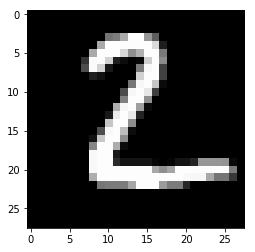

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_original[1], cmap='gray')
print(y[1])

In the next cell, the numpy array is standardized.

In [29]:
# preprocess
x_original = np.expand_dims(x_original, axis=3)
x_original = x_original.astype('float32') / 255
y = np_utils.to_categorical(y, 10)

In the below cell, the model will be evaluated and test accuracy will be calculated.

In [30]:
# evaluate
scores = model.evaluate(x_original, y, verbose=0)
print('model test loss:    ', scores[0]*100)
print('model test accuracy:', scores[1]*100)
model_accuracy = scores[1]*100

model test loss:     6.149627626761794
model test accuracy: 98.04


ART exposes many attacks like FGM, NewtonFool, DeepFool, Carlini etc. The code below shows how to use one of ART's attack methods (Fast Gradient Method or FGM) to craft adversarial samples based on x_test

In [31]:
from art.attacks.fast_gradient import FastGradientMethod

# configuration
epsilon = 0.2

# create crafter object
crafter = FastGradientMethod(classifier, eps=epsilon)

# craft samples on x_test (stored in variable x_original)
x_adv_samples = crafter.generate(x_original)

outfile = os.path.join(os.getcwd(), 'adv_samples')
np.savez(outfile, x_original=x_original, x_adversarial=x_adv_samples, y=y)

print("Number of adversarial samples crafted:", len(x_adv_samples))
print("adversarial samples saved to:", outfile)

Number of adversarial samples crafted: 10000
adversarial samples saved to: etc/notebooks/art/adv_samples


The below functions can be used for gathering metrics like model robustness, confidence metric, perturbation metric

In [32]:
import numpy.linalg as la
import json


def get_metrics(model, x_original, x_adv_samples, y):
    scores = model.evaluate(x_original, y, verbose=0)
    model_accuracy_on_non_adversarial_samples = scores[1] * 100

    y_pred = model.predict(x_original, verbose=0)
    y_pred_adv = model.predict(x_adv_samples, verbose=0)

    scores = model.evaluate(x_adv_samples, y, verbose=0)
    model_accuracy_on_adversarial_samples = scores[1] * 100

    pert_metric = get_perturbation_metric(x_original, x_adv_samples, y_pred, y_pred_adv, ord=2)
    conf_metric = get_confidence_metric(y_pred, y_pred_adv)

    data = {
        "model accuracy on test data:": model_accuracy_on_non_adversarial_samples,
        "model accuracy on adversarial samples": model_accuracy_on_adversarial_samples,
        "reduction in confidence": conf_metric * 100,
        "average perturbation": pert_metric * 100
    }
    return data


def get_perturbation_metric(x_original, x_adv, y_pred, y_pred_adv, ord=2):

    idxs = (np.argmax(y_pred_adv, axis=1) != np.argmax(y_pred, axis=1))

    if np.sum(idxs) == 0.0:
        return 0

    perts_norm = la.norm((x_adv - x_original).reshape(x_original.shape[0], -1), ord, axis=1)
    perts_norm = perts_norm[idxs]

    return np.mean(perts_norm / la.norm(x_original[idxs].reshape(np.sum(idxs), -1), ord, axis=1))


# This computes the change in confidence for all images in the test set
def get_confidence_metric(y_pred, y_pred_adv):

    y_classidx = np.argmax(y_pred, axis=1)
    y_classconf = y_pred[np.arange(y_pred.shape[0]), y_classidx]

    y_adv_classidx = np.argmax(y_pred_adv, axis=1)
    y_adv_classconf = y_pred_adv[np.arange(y_pred_adv.shape[0]), y_adv_classidx]

    idxs = (y_classidx == y_adv_classidx)

    if np.sum(idxs) == 0.0:
        return 0

    idxnonzero = y_classconf != 0
    idxs = idxs & idxnonzero

    return np.mean((y_classconf[idxs] - y_adv_classconf[idxs]) / y_classconf[idxs])

The below cell will display the following

1. Model accuracy on test data
2. Model robustness on adversarial samples
3. Reduction in confidence
4. Perturbation metric

In [33]:
result = get_metrics(model,x_original,x_adv_samples, y)

print(json.dumps(result, indent=4, sort_keys=True))

{
    "average perturbation": 46.828266978263855,
    "model accuracy on adversarial samples": 54.120000000000005,
    "model accuracy on test data:": 98.04,
    "reduction in confidence": 29.92871403694153
}


In [34]:
# convert the numpy array, so that the adversarial images can be visualized

x_adv = (x_adv_samples * 255).astype('int')
x_adv = x_adv[:, :, :, 0]
y = np.argmax(y, axis=1)

And visualize an adversarial samples

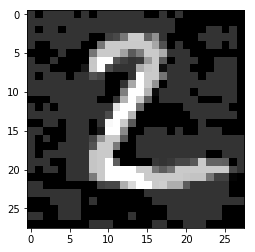

In [35]:
plt.imshow(x_adv[1], cmap='gray');

### 4.2 Generate adversarial samples with ART (asynchronously using FfDL) <a id="artWithFfDL"></a>

As its name suggests, FGM is a relatively short running method to generate adversarial samples. Other attack techniques can take much longer and therefore you may want to use additional computing resources and generate adversarial samples through an asynchronous Watsom ML training request. This section shows how to gather the relevant information to execute FGM as an asynchronous FfDL training job. 

Lets first create two COS buckets.

In [36]:
from uuid import uuid4

bucket_uid = str(uuid4())
buckets = ['robustnesscheck-data-' + bucket_uid,
           'robustnesscheck-results-' + bucket_uid]

for bucket in buckets:
    print('Creating bucket "{}" ...'.format(bucket))
    try:
        cos.create_bucket(Bucket=bucket)
    except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
        print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "robustnesscheck-data-136f29a1-9735-4f6c-8901-ef9426f2aeef" ...
Creating bucket "robustnesscheck-results-136f29a1-9735-4f6c-8901-ef9426f2aeef" ...


In [37]:
robustnesscheck_data_bucket = buckets[0]
robustnesscheck_result_bucket = buckets[1]

Upload all the artifacts (`mnist.npz`, `keras_original_model.json`, `keras_original_model.hdf5`) to the `robustnesscheck_data_bucket`

In [38]:
# upload

bucket_obj = cos.Bucket(robustnesscheck_data_bucket)
bucket_obj.upload_file(dataset_filename, dataset_filename)
print('{} is uploaded to {}.'.format(dataset_filename, robustnesscheck_data_bucket))

bucket_obj.upload_file(weights_filename, weights_filename)
print('{} is uploaded to {}.'.format(weights_filename, robustnesscheck_data_bucket))

bucket_obj = cos.Bucket(robustnesscheck_data_bucket)
bucket_obj.upload_file(network_definition_filename, network_definition_filename)
print('{} is uploaded to {}.'.format(network_definition_filename, robustnesscheck_data_bucket))

mnist.npz is uploaded to robustnesscheck-data-136f29a1-9735-4f6c-8901-ef9426f2aeef.
keras_original_model.hdf5 is uploaded to robustnesscheck-data-136f29a1-9735-4f6c-8901-ef9426f2aeef.
keras_original_model.json is uploaded to robustnesscheck-data-136f29a1-9735-4f6c-8901-ef9426f2aeef.


Create a Python script that generates adversarial samples to check robustness using FGM (Fast Gradient Method) from the ART library

In [39]:
script_filename  = "robustness_check.py"
archive_filename = 'model.zip'

In [40]:
%%writefile $script_filename

import os
import sys
import numpy as np
import numpy.linalg as la
import json

from keras.models import model_from_json
from art.classifiers.keras import KerasClassifier
from keras.utils import np_utils
from art.attacks.fast_gradient import FastGradientMethod


def get_metrics(model, x_original, x_adv_samples, y):
    scores = model.evaluate(x_original, y, verbose=0)
    model_accuracy_on_non_adversarial_samples = scores[1] * 100

    y_pred = model.predict(x_original, verbose=0)
    y_pred_adv = model.predict(x_adv_samples, verbose=0)

    scores = model.evaluate(x_adv_samples, y, verbose=0)
    model_accuracy_on_adversarial_samples = scores[1] * 100

    pert_metric = get_perturbation_metric(x_original, x_adv_samples, y_pred, y_pred_adv, ord=2)
    conf_metric = get_confidence_metric(y_pred, y_pred_adv)

    data = {
        "model accuracy on test data:": model_accuracy_on_non_adversarial_samples,
        "model accuracy on adversarial samples": model_accuracy_on_adversarial_samples,
        "reduction in confidence": conf_metric * 100,
        "average perturbation": pert_metric * 100
    }
    return data


def get_perturbation_metric(x_original, x_adv, y_pred, y_pred_adv, ord=2):

    idxs = (np.argmax(y_pred_adv, axis=1) != np.argmax(y_pred, axis=1))

    if np.sum(idxs) == 0.0:
        return 0

    perts_norm = la.norm((x_adv - x_original).reshape(x_original.shape[0], -1), ord, axis=1)
    perts_norm = perts_norm[idxs]

    return np.mean(perts_norm / la.norm(x_original[idxs].reshape(np.sum(idxs), -1), ord, axis=1))


# This computes the change in confidence for all images in the test set
def get_confidence_metric(y_pred, y_pred_adv):

    y_classidx = np.argmax(y_pred, axis=1)
    y_classconf = y_pred[np.arange(y_pred.shape[0]), y_classidx]

    y_adv_classidx = np.argmax(y_pred_adv, axis=1)
    y_adv_classconf = y_pred_adv[np.arange(y_pred_adv.shape[0]), y_adv_classidx]

    idxs = (y_classidx == y_adv_classidx)

    if np.sum(idxs) == 0.0:
        return 0

    idxnonzero = y_classconf != 0
    idxs = idxs & idxnonzero

    return np.mean((y_classconf[idxs] - y_adv_classconf[idxs]) / y_classconf[idxs])


def main(argv):
    if len(argv) < 2:
        sys.exit("Not enough arguments provided.")

    global network_definition_filename, weights_filename, dataset_filename

    i = 1
    while i <= 8:
        arg = str(argv[i])
        print(arg)
        if arg == "--data":
            dataset_filename = os.path.join(os.environ["DATA_DIR"], str(argv[i+1]))
        if arg == "--networkdefinition":
            network_definition_filename = os.path.join(os.environ["DATA_DIR"], str(argv[i+1]))
        if arg == "--weights":
            weights_filename = os.path.join(os.environ["DATA_DIR"], str(argv[i+1]))
        if arg == "--epsilon":
            epsilon = float(argv[i+1])

        i += 2

    print("dataset : ", dataset_filename)
    print("network definition : ", network_definition_filename)
    print("weights : " ,weights_filename)

    # load & compile model
    json_file = open(network_definition_filename, 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    model.load_weights(weights_filename)
    comp_params = {'loss': 'categorical_crossentropy',
                   'optimizer': 'adam',
                   'metrics': ['accuracy']}
    model.compile(**comp_params)

    # create keras classifier
    classifier = KerasClassifier((0, 1), model)

    # load data set
    pf = np.load(dataset_filename)

    x = pf['x_test']
    y = pf['y_test']

    # pre-process numpy array

    x = np.expand_dims(x, axis=3)
    x = x.astype('float32') / 255

    y = np_utils.to_categorical(y, 10)

    # craft adversarial samples using FGSM
    crafter = FastGradientMethod(classifier, eps=epsilon)
    x_samples = crafter.generate(x)

    # obtain all metrics (robustness score, perturbation metric, reduction in confidence)
    metrics = get_metrics(model, x,x_samples, y)

    print("metrics : ", metrics)
    
    report_file = os.path.join(os.environ["RESULT_DIR"], "report.txt")

    with open(report_file, "w") as report:
        report.write(json.dumps(metrics))
    
    adv_samples_file = os.path.join(os.environ["RESULT_DIR"], 'adv_samples')
    print("adversarial samples saved to : ", adv_samples_file)
    np.savez(adv_samples_file, x_original=x, x_adversarial=x_samples, y=y)


if __name__ == "__main__":
    main(sys.argv)

Writing robustness_check.py


Create a zip archive (TODO: NOT that contains the ART library along with) `robustness_check.py` code

In [41]:
# create zip archive
# TODO: exclude folder like .git ?
# !zip model.zip -r ./adversarial-robustness-toolbox robustness_check.py -x *.git*
!zip -r {archive_filename} {script_filename}

  adding: robustness_check.py (deflated 67%)


#### Prepare model definition metadata. 

<b> Note: </b> Execution command points to `robustness_check.py` and four arguments are passed to the script.

1. data (`mnist.npz`)
2. networkdefinition (`keras_original_model.json`)
3. weights (`keras_original_model.hdf5`)
4. epsilon (`0.2` or `0.1`)

In [42]:
training_command = "\
pip3 install keras; \
pip install https://github.com/IBM/adversarial-robustness-toolbox/zipball/master; \
python3 robustness_check.py \
  --epsilon 0.2 \
  --data ${DATA_DIR}/mnist.npz \
  --networkdefinition ${DATA_DIR}/keras_original_model.json \
  --weights ${DATA_DIR}/keras_original_model.hdf5"

manifest = {
  "name": "art_robustness_check",
  "description": "Generates adversarial samples to check robustness using FGM",
  "version": "1.0",
  "gpus": 0,
  "cpus": 2,
  "memory": "2Gb",
  "data_stores": [
    {
      "id": "sl-internal-os",
      "type": "s3_datastore",
      "training_data": {
        "container": robustnesscheck_data_bucket
      },
      "training_results": {
        "container": robustnesscheck_result_bucket
      },
      "connection": {
        "type": "s3_datastore",
        "auth_url": cos_service_endpoint,
        "user_name": cos_credentials['cos_hmac_keys']['access_key_id'],
        "password": cos_credentials['cos_hmac_keys']['secret_access_key']
      }
    }
  ],
  "framework": {
    "name": "tensorflow",
    "version": "1.5.0-py3",
    "command": training_command
  },
  "evaluation_metrics": {
    "type": "tensorboard",
    "in": "$JOB_STATE_DIR/logs/tb"
  }
}

yaml.dump(manifest, open("manifest.yml", "w"), default_flow_style=False)

Training metadata to configure the adversarial sample generation based on FGM has been gathered and can now be passed to a training job with FfDL. 

In [43]:
# Start training execution

out = !{ffdl} train "manifest.yml" "model.zip"
out

["Deploying model with manifest 'manifest.yml' and model file 'model.zip'...",
 'Model ID: training-e1S2uaIig',
 'OK']

In [44]:
# Monitor the training logs

if "Model ID" in out[1]:
    model_id = out.fields()[1][-1]
    !{ffdl} logs --follow {model_id}

Getting model training logs for 'training-e1S2uaIig'...
Status: PENDING
Status: Not Started
Training with training/test data at:
  DATA_DIR: /job/robustnesscheck-data-136f29a1-9735-4f6c-8901-ef9426f2aeef
  MODEL_DIR: /job/model-code
  TRAINING_JOB: 
  TRAINING_COMMAND: pip3 install keras; pip install https://github.com/IBM/adversarial-robustness-toolbox/zipball/master; python3 robustness_check.py   --epsilon 0.2   --data ${DATA_DIR}/mnist.npz   --networkdefinition ${DATA_DIR}/keras_original_model.json   --weights ${DATA_DIR}/keras_original_model.hdf5
Storing trained model at:
  RESULT_DIR: /job/robustnesscheck-results-136f29a1-9735-4f6c-8901-ef9426f2aeef
Contents of $MODEL_DIR
total 20
drwxrwxrwx 2 6342627 root 4096 Jun  9 01:40 .
drwxrwxrwx 6 root    root 4096 Jun  9 01:40 ..
-rwxrwxrwx 1 6342627 root 2650 Jun  8 18:29 convolutional_keras.py
-rwxrwxrwx 1 6342627 root 4560 Jun  8 18:39 robustness_check.py
Contents of $DATA_DIR
total 25332
drwxr-xr-x 2 6342627 root     4096 Jun  9 01:40

  Running setup.py install for adversarial-robustness-toolbox: started
    Running setup.py install for adversarial-robustness-toolbox: finished with status 'done'
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
2018-06-09 01:40:48.673881: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
--epsilon
--data
--networkdefinition
--weights
dataset :  /job/robustnesscheck-data-136f29a1-9735-4f6c-8901-ef9426f2aeef/mnist.npz
network definition :  /job/robustnessc

The above training job will create a report (`report.txt`). The file is available in COS (bucket = `robustnesscheck_result_bucket`) 

In [45]:
report_file = os.path.join(model_id, "report.txt")
bucket_obj = cos.Bucket(robustnesscheck_result_bucket)

bucket_obj.download_file(report_file, "report.txt")

with open('report.txt', "r") as report:
    result = json.load(report)
    
print(json.dumps(result, indent=4, sort_keys=True))

{
    "average perturbation": 46.828266978263855,
    "model accuracy on adversarial samples": 54.120000000000005,
    "model accuracy on test data:": 98.04,
    "reduction in confidence": 29.92871403694153
}


Download the adversarial samples that were stored to COS using the below command

In [46]:
samples_file = os.path.join(model_id, "adv_samples.npz")
print('Downloading {}/{} ...'.format(robustnesscheck_result_bucket, samples_file))
bucket_obj = cos.Bucket(robustnesscheck_result_bucket)
bucket_obj.download_file(samples_file, "adv_samples_from_cos.npz")
print('Downloaded:', "adv_samples_from_cos.npz")

Downloaded: adv_samples_from_cos.npz


Compare original with adversarial images

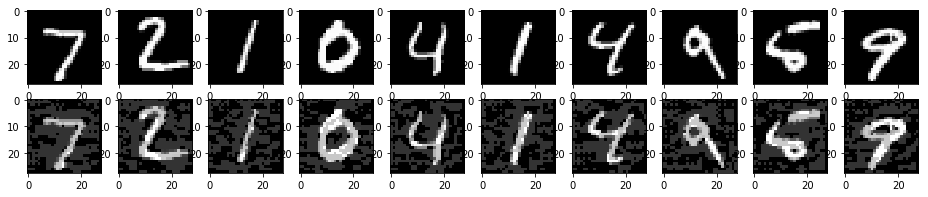

In [47]:
x_adv_samples = np.load("adv_samples_from_cos.npz")
x_original    = x_adv_samples["x_original"]
x_adversarial = x_adv_samples["x_adversarial"]
x_orig = (x_original    * 255).astype('int')[:, :, :, 0]
x_adv  = (x_adversarial * 255).astype('int')[:, :, :, 0]

cols   = 10
rows   = 2
images = list(x_orig[:10]) + list(x_adv[:10])
fig    = plt.figure(figsize=(16, 3))

for i in range(0, len(images)):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(images[i], cmap='gray')

plt.show()

## 5. Summary and next steps

This notebook only looked at one adversarial robustness technique (FGM). ART contains many more attacks, metrics and defenses to help you understand and improve your model's robustness.  You can use this notebook as a template to experiment with all aspects of ART. 

## Authors


- **Anupama Murthi**  (<anupama.murthi@ibm.com>)

- **Vijay Arya**  (<vijay.arya@in.ibm.com>)

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.